# 2D Integrator

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.sparse.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
sns.set(style='darkgrid', palette='hls')

from FPE.integrator_2D import FPE_integrator_2D

%load_ext autoreload
%autoreload 2

In [22]:
D = 1.0
dx = 0.1
dy = 0.1
dt = 0.01
x_array = np.arange(-1, 1, dx)
y_array = np.arange(-1, 1, dy)


def initDiffusionSparse(D, dt, dx, dy, N, Nx, Ny):

    expImp = 0.5
    alpha = D * dt / (dx * dy)

    AMat = sp.lil_matrix((N, N))
    BMat = sp.lil_matrix((N, N))

    # Bulk term initializations
    AMat.setdiag(1 + 4 * alpha * expImp)
    AMat.setdiag(-1 * expImp * alpha, k=1)
    AMat.setdiag(-1 * expImp * alpha, k=-1)
    AMat.setdiag(-1 * expImp * alpha, k=Nx)
    AMat.setdiag(-1 * expImp * alpha, k=-Nx)

    BMat.setdiag(1 - 4 * alpha * (1 - expImp))
    BMat.setdiag(alpha * (1 - expImp), k=1)
    BMat.setdiag(alpha * (1 - expImp), k=-1)
    BMat.setdiag(alpha * (1 - expImp), k=Nx)
    BMat.setdiag(alpha * (1 - expImp), k=-Nx)

    # self._initializeBoundaryTerms(alpha)

    # convert to csr format
    AMat = AMat.tocsc()
    BMat = BMat.tocsc()

    CMat = inv(AMat).dot(BMat)

    return AMat, BMat, CMat

def initDiffusionNumpy(D, dt, dx, dy, N, Nx, Ny):
    alpha = D * dt / (dx * dy)
    expImp = 0.5

    AMat = np.zeros((N, N))
    BMat = np.zeros((N, N))

    # Bulk term initializations
    AMat = (
        np.diag(1 + 4 * alpha * expImp * np.ones(N))
        - np.diag(expImp * alpha * np.ones(N - 1), k=1)
        - np.diag(expImp * alpha * np.ones(N - 1), k=-1)
        # far off-diagonal terms representing y-transitions
        - np.diag(expImp * alpha * np.ones(N - Nx), k=Nx)
        - np.diag(expImp * alpha * np.ones(N - Nx), k=-Nx)
    )

    BMat = (
        np.diag(1 - 4 * alpha * (1 - expImp) * np.ones(N))
        + np.diag(alpha * (1 - expImp) * np.ones(N - 1), k=1)
        + np.diag(alpha * (1 - expImp) * np.ones(N - 1), k=-1)
        + np.diag(alpha * (1 - expImp) * np.ones(N - Nx), k=Nx)
        + np.diag(alpha * (1 - expImp) * np.ones(N - Nx), k=-Nx)
    )

    # self._initializeBoundaryTerms(alpha)

    CMat = np.matmul(np.linalg.inv(AMat), BMat)
    return AMat, BMat, CMat

# mimic constructor
def test_constructor(
    D, dt, dx, dy, x_array, y_array, is_sparse
):

    Nx = len(x_array)
    Ny = len(y_array)
    N = Nx * Ny

    if is_sparse:
        initDiffusionSparse(D, dt, dx, dy, N, Nx, Ny)
    else:
        initDiffusionNumpy(D, dt, dx, dy, N, Nx, Ny)


In [3]:
dx_arr = [0.2, 0.1, 0.075, 0.05, 0.025]
time_arr_numpy = []

for dx in dx_arr:
    x_array = np.arange(-1, 1, dx)
    y_array = np.arange(-1, 1, dx)

    exec_time = timeit.timeit(lambda: test_constructor(D, dt, dx, dx, x_array, y_array, False), number=3)
    time_arr_numpy.append(exec_time)
    print(f"execution time: {exec_time} seconds for dx={dx}")


execution time: 0.015207500022370368 seconds for dx=0.2
execution time: 0.05665924999630079 seconds for dx=0.1
execution time: 0.13472299999557436 seconds for dx=0.075
execution time: 1.1011290420137811 seconds for dx=0.05
execution time: 58.759513249999145 seconds for dx=0.025


In [4]:

time_arr_sparse = []

for dx in dx_arr:
    x_array = np.arange(-1, 1, dx)
    y_array = np.arange(-1, 1, dx)

    exec_time = timeit.timeit(lambda: test_constructor(D, dt, dx, dx, x_array, y_array, True), number=3)
    time_arr_sparse.append(exec_time)
    print(f"execution time: {exec_time} seconds for dx={dx}")

execution time: 0.053899458987871185 seconds for dx=0.2
execution time: 0.22722808297839947 seconds for dx=0.1
execution time: 0.4549411250045523 seconds for dx=0.075
execution time: 1.4029828749771696 seconds for dx=0.05
execution time: 18.119494708022103 seconds for dx=0.025


In [5]:
# Here, we focus in on the 0.05 -> 0.025 regime
dx_arr = [0.05, 0.045, 0.04, 0.035, 0.03, 0.025, 0.02]
time_arr_numpy_alt = []

for dx in dx_arr:
    x_array = np.arange(-1, 1, dx)
    y_array = np.arange(-1, 1, dx)

    exec_time = timeit.timeit(lambda: test_constructor(D, dt, dx, dx, x_array, y_array, False), number=3)
    time_arr_numpy_alt.append(exec_time)
    print(f"execution time: {exec_time} seconds for dx={dx}")

execution time: 0.8784391670196783 seconds for dx=0.05
execution time: 1.797804834000999 seconds for dx=0.045
execution time: 3.1096318750060163 seconds for dx=0.04
execution time: 7.384130582999205 seconds for dx=0.035
execution time: 18.9643619999988 seconds for dx=0.03
execution time: 57.38192620899645 seconds for dx=0.025
execution time: 227.0701688330155 seconds for dx=0.02


In [7]:
dx_arr = [0.05, 0.045, 0.04, 0.035, 0.03, 0.025, 0.02]
time_arr_sparse_alt = []

for dx in dx_arr:
    x_array = np.arange(-1, 1, dx)
    y_array = np.arange(-1, 1, dx)

    exec_time = timeit.timeit(lambda: test_constructor(D, dt, dx, dx, x_array, y_array, True), number=3)
    time_arr_sparse_alt.append(exec_time)
    print(f"execution time: {exec_time} seconds for dx={dx}")

execution time: 1.3710739579983056 seconds for dx=0.05
execution time: 2.039973957987968 seconds for dx=0.045
execution time: 2.8526476249971893 seconds for dx=0.04
execution time: 4.879185333993519 seconds for dx=0.035
execution time: 8.510112125019077 seconds for dx=0.03
execution time: 17.66603408299852 seconds for dx=0.025
execution time: 53.48611362502561 seconds for dx=0.02


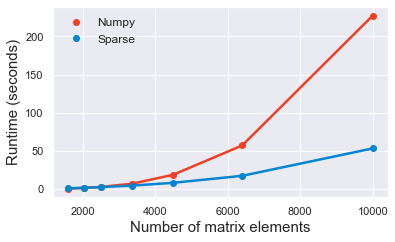

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

n_arr = []
for dx in dx_arr:
    x_array = np.arange(-1, 1, dx)
    n_arr.append(len(x_array) ** 2)

ax.plot(n_arr, time_arr_numpy_alt, linewidth=2.5, color=sns.xkcd_rgb["tomato"])
ax.plot(n_arr, time_arr_sparse_alt, linewidth=2.5, color=sns.xkcd_rgb["cerulean"])

ax.plot(n_arr, time_arr_numpy_alt, 'o', markersize=6, color=sns.xkcd_rgb["tomato"], label="Numpy")
ax.plot(n_arr, time_arr_sparse_alt, 'o', markersize=6, color=sns.xkcd_rgb["cerulean"], label="Sparse")

ax.set_xlabel(r"Number of matrix elements", fontsize=15)
ax.set_ylabel(r"Runtime (seconds)", fontsize=15)

ax.legend(fontsize=12, frameon=False)


In [23]:
# Finally, we want to actually check that the two routines are producing the same output
dx = 0.05
x_array = np.arange(-1, 1, dx)
Nx = len(x_array)
N = Nx * Nx

A_np, B_np, C_np = initDiffusionNumpy(D, dt, dx, dx, N, Nx, Nx)
A_sp, B_sp, C_sp = initDiffusionSparse(D, dt, dx, dx, N, Nx, Nx)


In [24]:
# Convert the scipy back into dense format

np.all(np.isclose((A_sp.toarray() - A_np), 0)), np.all(np.isclose((B_sp.toarray() - B_np), 0)), np.all(np.isclose((C_sp.toarray() - C_np), 0))

(True, True, True)

In [ ]:
# So, it lookd like this works, and given that we will primarily be working
# with large arrays, we can default to the sparse matrix initialization methods